# Description

Ensaio de algoritmos de Regressão.

Algoritmos utilizados:

- Linear Regression
- Linear Regression Lasso
- Linear Regression Ridge
- Linear Regression Elastic Net
- Polinomial Regression
- Polinomial Regression Lasso
- Polinomial Regression Ridge
- Polinomial Regression Elastic Net
- Decision Tree Regressor
- Random Forest Regressor

Métricas de Performance:

- R2
- MSE
- RMSE
- MAE
- MAPE


# Imports

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn import preprocessing as pp
from sklearn import tree
from sklearn import ensemble as en

import optuna

import warnings
warnings.filterwarnings("ignore")

C:\Users\Notebook\anaconda3\envs\f_machine_learning_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# Dados de Treino
X_train = pd.read_csv('datasets/regressao/X_training.csv')
y_train = pd.read_csv('datasets/regressao/y_training.csv')

# Dados de Validação
X_val = pd.read_csv('datasets/regressao/X_validation.csv')
y_val = pd.read_csv('datasets/regressao/y_val.csv')

# Dados de Teste
X_test = pd.read_csv('datasets/regressao/X_test.csv')
y_test = pd.read_csv('datasets/regressao/y_test.csv')

In [3]:
print(f'Dados de Treino:    Linhas: {X_train.shape[0]}   Colunas: {X_train.shape[1]}')
print(f'Dados de Validação: Linhas: {X_val.shape[0]}   Colunas: {X_val.shape[1]}')
print(f'Dados de Teste:     Linhas: {X_test.shape[0]}   Colunas: {X_test.shape[1]}')

Dados de Treino:    Linhas: 10547   Colunas: 13
Dados de Validação: Linhas: 4521   Colunas: 13
Dados de Teste:     Linhas: 3767   Colunas: 13


# Ensaio

Paramatro otimizados:

|  Algoritmo                        | Parâmetros                         |
| ----------------------------------|------------------------------------|
| Linear Regression                 | -                   |
| Linear Regression Lasso           | alpha, max_iter                    |
| Linear Regression Ridge           | alpha, max_iter                    |
| Linear Regression Elastic Net     | alpha, max_iter, l1_ratio          |
| Polinomial Regression             | degree                             |
| Polinomial Regression Lasso       | degree, alpha, max_iter            |
| Polinomial Regression Ridge       | degree, alpha, max_iter            |
| Polinomial Regression Elastic Net | degree, alpha, l1_ratio, max_iter  |
| Decision Tree Regressor           | max_depth                          |
| Random Forest Regressor           | n_estimators, max_depth            |

## Functions

In [4]:
def ml_metrics(y_val, y_pred, model_name, k): 
    r2        = mt.r2_score(y_val, y_pred)
    mse       = mt.mean_squared_error(y_val, y_pred)
    rmse      = np.sqrt(mt.mean_squared_error(y_val, y_pred))
    mae       = mt.mean_absolute_error(y_val, y_pred)
    mape      = mt.mean_absolute_percentage_error(y_val, y_pred)
    df_results = pd.DataFrame( {'Model':[model_name],
                                'Dataset': [k],
                                'R²': [r2],
                                'MSE': [mse],
                                'RMSE': [rmse],
                                'MAE': [mae],
                                'MAPE': [mape]
                                })
    
    return df_results

In [10]:
def ensaio(model, parameters, model_name, n_iter):
    
    def test_tuning(trial):

        parameters_values = {}
       
        for name in list(parameters.keys()):
            # dicionário de parametros
            if parameters[name]['type'] == 'int':
                parameters_values[name] = trial.suggest_int(name, parameters[name]['min'], parameters[name]['max'])
            if parameters[name]['type'] == 'float':
                parameters_values[name] = trial.suggest_float(name, parameters[name]['min'], parameters[name]['max'])
                                
        ## Transformação de dados
        if 'degree' in list(parameters.keys()):
            poly = pp.PolynomialFeatures(degree=parameters_values['degree'])
            X_train_poly = poly.fit_transform(X_train)
            X_val_poly = poly.transform(X_val)
            
            # definindo modelo
            parameters_values.pop('degree')
            model.set_params(**parameters_values)
        else:
            X_train_poly = X_train
            X_val_poly = X_val
            
            # definindo modelo
            model.set_params(**parameters_values)

        model.fit(X_train_poly, y_train)

        y_pred = model.predict(X_val_poly)

        return np.sqrt(mt.mean_squared_error(y_val, y_pred))
    
    df_results = pd.DataFrame()
    best_params = {}
    
    if len(list(parameters.keys())) > 0:
        # Optuna fine tuning
        model_study = optuna.create_study(direction='minimize')
        model_study.optimize(test_tuning, n_trials=n_iter)
    
        best_params = model_study.best_params
        
    ## Transformação de dados
    if 'degree' in list(parameters.keys()):
        poly = pp.PolynomialFeatures(degree=best_params['degree'])
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        X_test_poly = poly.fit_transform(X_test)
    
         # Best model
        best_params.pop('degree')
        model.set_params(**best_params)
    else:
        X_train_poly = X_train
        X_val_poly = X_val
        X_test_poly = X_test
        
        # Best model
        model.set_params(**best_params)
        
    # Model fit 
    model.fit(X_train_poly, y_train)
    
    #### Train
    # Model Predict
    y_pred = model.predict(X_train_poly)
    train_metrics = ml_metrics(y_train, y_pred, model_name, 'Train')
    
    #### Validation
    # Model Predict
    y_pred = model.predict(X_val_poly)
    validation_metrics = ml_metrics(y_val, y_pred, model_name, 'Validation')
    
    #### Test
    # Model Predict
    y_pred = model.predict(X_test_poly)
    test_metrics = ml_metrics(y_test, y_pred, model_name, 'Test')
    
    df_results = pd.concat([df_results, train_metrics], axis=0)
    df_results = pd.concat([df_results, validation_metrics], axis=0)
    df_results = pd.concat([df_results, test_metrics], axis=0)
    
    return df_results

## Definindo parametros dos modelos

In [11]:
lr_lasso_parameters = {'alpha':{'type':'float', 'min':0, 'max':1}, 'max_iter':{'type':'int','min': 1, 'max':100}}
lr_ridge_parameters = {'alpha':{'type':'float', 'min':0, 'max':1}, 'max_iter':{'type':'int','min': 1, 'max':100}}
lr_elastic_net_parameters = {'alpha':{'type':'float', 'min':0, 'max':1}, 'max_iter':{'type':'int','min': 1, 'max':100}, 'l1_ratio':{'type':'float', 'min':0, 'max': 1}}

poly_lasso_parameters = {'degree':{'type':'int', 'min': 2, 'max': 4},'alpha':{'type':'float', 'min':0, 'max':1}, 'max_iter':{'type':'int','min': 1, 'max':100}}
poly_ridge_parameters = {'degree':{'type':'int', 'min': 2, 'max': 4},'alpha':{'type':'float', 'min':0, 'max':1}, 'max_iter':{'type':'int','min': 1, 'max':100}}
poly_elastic_net_parameters={'degree':{'type':'int', 'min': 2, 'max': 4},'alpha':{'type':'float', 'min':0, 'max':1}, 'max_iter':{'type':'int','min': 1, 'max':100}, 'l1_ratio':{'type':'float', 'min':0, 'max': 1}}

dt_parameters = {'max_depth': {'type': 'int', 'min': 2, 'max': 100}}
rf_parameters = {'n_estimators': {'type': 'int', 'min': 2, 'max': 50}, 'max_depth': {'type': 'int', 'min': 2, 'max': 100}}

## Definindo parametros do ensaio

In [12]:
dict_models = {
    'Linear Regression': {'model': lm.LinearRegression(), 'parameters': {}},
    'Linear Regression - Lasso' : {'model':lm.Lasso(), 'parameters': lr_lasso_parameters},
    'Linear Regression - Ridge': {'model': lm.Ridge(), 'parameters': lr_ridge_parameters},
    'Linear Regression - Elastict Net': {'model': lm.ElasticNet(), 'parameters': lr_elastic_net_parameters},
    'Polynomial Regression': {'model': lm.LinearRegression(), 'parameters': {}},
    'Polynomial Regression - Lasso': {'model': lm.Lasso(), 'parameters': poly_lasso_parameters},
    'Polynomial Regression - Ridge': {'model': lm.Ridge(), 'parameters': poly_ridge_parameters},
    'Polynomial Regression - Elastict Net': {'model': lm.ElasticNet(), 'parameters': poly_elastic_net_parameters},
    'Decision Tree': {'model': tree.DecisionTreeRegressor(), 'parameters': dt_parameters},
    'Random Forest': {'model': en.RandomForestRegressor(), 'parameters': rf_parameters}
}

## Ensaiando Modelos

In [13]:
df_results = pd.DataFrame()
for i_model in list(dict_models.keys()):
    model_name = i_model
    model = dict_models[i_model]['model']
    model_params = dict_models[i_model]['parameters']
    print(f'{model_name}')
    
    i_results = ensaio(model, model_params, model_name, 50)
    
    df_results = pd.concat([df_results, i_results], axis=0)
df_results

[I 2023-08-27 13:46:01,601] A new study created in memory with name: no-name-997d07e4-2a82-4746-a146-fd00bdc02e8c


Linear Regression
Linear Regression - Lasso


[I 2023-08-27 13:46:01,613] Trial 0 finished with value: 21.751321822814337 and parameters: {'alpha': 0.7201216874761277, 'max_iter': 28}. Best is trial 0 with value: 21.751321822814337.
[I 2023-08-27 13:46:01,630] Trial 1 finished with value: 21.737846572496878 and parameters: {'alpha': 0.4857411825432826, 'max_iter': 24}. Best is trial 1 with value: 21.737846572496878.
[I 2023-08-27 13:46:01,645] Trial 2 finished with value: 21.747680263755054 and parameters: {'alpha': 0.6655460518849738, 'max_iter': 21}. Best is trial 1 with value: 21.737846572496878.
[I 2023-08-27 13:46:01,667] Trial 3 finished with value: 21.47662793163956 and parameters: {'alpha': 0.14562318232044447, 'max_iter': 12}. Best is trial 3 with value: 21.47662793163956.
[I 2023-08-27 13:46:01,685] Trial 4 finished with value: 21.553732184592473 and parameters: {'alpha': 0.2298438323812696, 'max_iter': 50}. Best is trial 3 with value: 21.47662793163956.
[I 2023-08-27 13:46:01,697] Trial 5 finished with value: 21.7432724

[I 2023-08-27 13:46:03,249] Trial 44 finished with value: 21.411008257523125 and parameters: {'alpha': 0.004966724619074509, 'max_iter': 85}. Best is trial 44 with value: 21.411008257523125.
[I 2023-08-27 13:46:03,301] Trial 45 finished with value: 21.41907443268955 and parameters: {'alpha': 0.050776789662581326, 'max_iter': 93}. Best is trial 44 with value: 21.411008257523125.
[I 2023-08-27 13:46:03,349] Trial 46 finished with value: 21.4508693773819 and parameters: {'alpha': 0.11304280005574281, 'max_iter': 97}. Best is trial 44 with value: 21.411008257523125.
[I 2023-08-27 13:46:03,374] Trial 47 finished with value: 21.74091510911173 and parameters: {'alpha': 0.5487593376634323, 'max_iter': 86}. Best is trial 44 with value: 21.411008257523125.
[I 2023-08-27 13:46:03,412] Trial 48 finished with value: 21.492844944591198 and parameters: {'alpha': 0.1645546518178903, 'max_iter': 87}. Best is trial 44 with value: 21.411008257523125.
[I 2023-08-27 13:46:03,460] Trial 49 finished with val

Linear Regression - Ridge


[I 2023-08-27 13:46:03,704] Trial 15 finished with value: 21.411346002480084 and parameters: {'alpha': 0.8217167644016072, 'max_iter': 64}. Best is trial 11 with value: 21.411340190655295.
[I 2023-08-27 13:46:03,722] Trial 16 finished with value: 21.411339923488395 and parameters: {'alpha': 0.9995180291199154, 'max_iter': 95}. Best is trial 16 with value: 21.411339923488395.
[I 2023-08-27 13:46:03,740] Trial 17 finished with value: 21.411345025481175 and parameters: {'alpha': 0.8499431159888728, 'max_iter': 90}. Best is trial 16 with value: 21.411339923488395.
[I 2023-08-27 13:46:03,756] Trial 18 finished with value: 21.41134945991032 and parameters: {'alpha': 0.7228607616437077, 'max_iter': 68}. Best is trial 16 with value: 21.411339923488395.
[I 2023-08-27 13:46:03,771] Trial 19 finished with value: 21.41134490687986 and parameters: {'alpha': 0.8533785265962383, 'max_iter': 67}. Best is trial 16 with value: 21.411339923488395.
[I 2023-08-27 13:46:03,787] Trial 20 finished with value:

[I 2023-08-27 13:46:04,518] Trial 7 finished with value: 21.419363027235104 and parameters: {'alpha': 0.042361604145924714, 'max_iter': 26, 'l1_ratio': 0.9682142643745032}. Best is trial 7 with value: 21.419363027235104.
[I 2023-08-27 13:46:04,531] Trial 8 finished with value: 21.51684657186991 and parameters: {'alpha': 0.13528735376608814, 'max_iter': 4, 'l1_ratio': 0.8707704375812153}. Best is trial 7 with value: 21.419363027235104.
[I 2023-08-27 13:46:04,567] Trial 9 finished with value: 21.415583730043604 and parameters: {'alpha': 0.005870957140001076, 'max_iter': 19, 'l1_ratio': 0.0502702968039912}. Best is trial 9 with value: 21.415583730043604.


Linear Regression - Elastict Net


[I 2023-08-27 13:46:04,598] Trial 10 finished with value: 21.70871725103892 and parameters: {'alpha': 0.6158695218202643, 'max_iter': 99, 'l1_ratio': 0.033760046608650424}. Best is trial 9 with value: 21.415583730043604.
[I 2023-08-27 13:46:04,642] Trial 11 finished with value: 21.427761332537603 and parameters: {'alpha': 0.024414284993023803, 'max_iter': 26, 'l1_ratio': 0.6251865175178093}. Best is trial 9 with value: 21.415583730043604.
[I 2023-08-27 13:46:04,673] Trial 12 finished with value: 21.643966979084748 and parameters: {'alpha': 0.2553771336888485, 'max_iter': 28, 'l1_ratio': 0.6282393552300232}. Best is trial 9 with value: 21.415583730043604.
[I 2023-08-27 13:46:04,719] Trial 13 finished with value: 21.43127700880548 and parameters: {'alpha': 0.013051896640071035, 'max_iter': 16, 'l1_ratio': 0.001117681946485094}. Best is trial 9 with value: 21.415583730043604.
[I 2023-08-27 13:46:04,754] Trial 14 finished with value: 21.58138925473043 and parameters: {'alpha': 0.2273133777

[I 2023-08-27 13:46:06,236] Trial 48 finished with value: 21.441101038378296 and parameters: {'alpha': 0.04900733326078859, 'max_iter': 94, 'l1_ratio': 0.7903777083846615}. Best is trial 36 with value: 21.411066674333487.
[I 2023-08-27 13:46:06,289] Trial 49 finished with value: 21.411099072513117 and parameters: {'alpha': 0.003778791916799821, 'max_iter': 65, 'l1_ratio': 0.8568497616883993}. Best is trial 36 with value: 21.411066674333487.
[I 2023-08-27 13:46:06,375] A new study created in memory with name: no-name-230a8c83-9969-4737-8bb7-c00bb27051e6


Polynomial Regression
Polynomial Regression - Lasso


[I 2023-08-27 13:46:06,789] Trial 0 finished with value: 21.67627095554115 and parameters: {'degree': 2, 'alpha': 0.6089184407691473, 'max_iter': 92}. Best is trial 0 with value: 21.67627095554115.
[I 2023-08-27 13:46:08,389] Trial 1 finished with value: 21.754242280726423 and parameters: {'degree': 4, 'alpha': 0.40888209329337943, 'max_iter': 10}. Best is trial 0 with value: 21.67627095554115.
[I 2023-08-27 13:46:14,069] Trial 2 finished with value: 21.55017514579101 and parameters: {'degree': 4, 'alpha': 0.19968384566836572, 'max_iter': 53}. Best is trial 2 with value: 21.55017514579101.
[I 2023-08-27 13:46:24,121] Trial 3 finished with value: 22.310229412939307 and parameters: {'degree': 4, 'alpha': 0.5047803243838084, 'max_iter': 100}. Best is trial 2 with value: 21.55017514579101.
[I 2023-08-27 13:46:31,306] Trial 4 finished with value: 22.15177371966955 and parameters: {'degree': 4, 'alpha': 0.49499627698178983, 'max_iter': 56}. Best is trial 2 with value: 21.55017514579101.
[I 2

[I 2023-08-27 13:47:24,576] Trial 41 finished with value: 21.098143487280215 and parameters: {'degree': 2, 'alpha': 0.004889362039591216, 'max_iter': 59}. Best is trial 14 with value: 21.09240639005194.
[I 2023-08-27 13:47:25,230] Trial 42 finished with value: 21.151833777261245 and parameters: {'degree': 2, 'alpha': 0.05895412636946272, 'max_iter': 52}. Best is trial 14 with value: 21.09240639005194.
[I 2023-08-27 13:47:25,922] Trial 43 finished with value: 21.203610507155524 and parameters: {'degree': 2, 'alpha': 0.10545820987160895, 'max_iter': 69}. Best is trial 14 with value: 21.09240639005194.
[I 2023-08-27 13:47:26,660] Trial 44 finished with value: 21.096689959524337 and parameters: {'degree': 2, 'alpha': 0.001823550967593081, 'max_iter': 56}. Best is trial 14 with value: 21.09240639005194.
[I 2023-08-27 13:47:27,096] Trial 45 finished with value: 21.144260526347008 and parameters: {'degree': 2, 'alpha': 0.049091773782767904, 'max_iter': 56}. Best is trial 14 with value: 21.092

Polynomial Regression - Ridge


[I 2023-08-27 13:47:34,705] Trial 1 finished with value: 116.39729131586574 and parameters: {'degree': 4, 'alpha': 0.673476178576976, 'max_iter': 88}. Best is trial 0 with value: 21.099416232691393.
[I 2023-08-27 13:47:34,740] Trial 2 finished with value: 21.108585454925503 and parameters: {'degree': 2, 'alpha': 0.04057638502748839, 'max_iter': 20}. Best is trial 0 with value: 21.099416232691393.
[I 2023-08-27 13:47:34,776] Trial 3 finished with value: 21.099399376146447 and parameters: {'degree': 2, 'alpha': 0.9688052095887, 'max_iter': 81}. Best is trial 3 with value: 21.099399376146447.
[I 2023-08-27 13:47:34,811] Trial 4 finished with value: 21.0995573377143 and parameters: {'degree': 2, 'alpha': 0.661693894431136, 'max_iter': 24}. Best is trial 3 with value: 21.099399376146447.
[I 2023-08-27 13:47:34,848] Trial 5 finished with value: 21.099586802119134 and parameters: {'degree': 2, 'alpha': 0.6351402440115368, 'max_iter': 85}. Best is trial 3 with value: 21.099399376146447.
[I 202

[I 2023-08-27 13:47:42,505] Trial 42 finished with value: 21.099429344862372 and parameters: {'degree': 2, 'alpha': 0.860786871623983, 'max_iter': 96}. Best is trial 39 with value: 21.09939419412128.
[I 2023-08-27 13:47:42,553] Trial 43 finished with value: 21.099395036473243 and parameters: {'degree': 2, 'alpha': 0.9916838629611121, 'max_iter': 89}. Best is trial 39 with value: 21.09939419412128.
[I 2023-08-27 13:47:42,598] Trial 44 finished with value: 21.099406632021314 and parameters: {'degree': 2, 'alpha': 0.9362075876086581, 'max_iter': 88}. Best is trial 39 with value: 21.09939419412128.
[I 2023-08-27 13:47:42,651] Trial 45 finished with value: 21.099422162345203 and parameters: {'degree': 2, 'alpha': 0.8815095643304404, 'max_iter': 82}. Best is trial 39 with value: 21.09939419412128.
[I 2023-08-27 13:47:42,705] Trial 46 finished with value: 21.099395684198708 and parameters: {'degree': 2, 'alpha': 0.9880675681972642, 'max_iter': 88}. Best is trial 39 with value: 21.099394194121

Polynomial Regression - Elastict Net


[I 2023-08-27 13:47:43,406] Trial 1 finished with value: 21.436209459705456 and parameters: {'degree': 2, 'alpha': 0.24761716549468937, 'max_iter': 28, 'l1_ratio': 0.48267175114056504}. Best is trial 1 with value: 21.436209459705456.
[I 2023-08-27 13:47:46,582] Trial 2 finished with value: 22.01377158860459 and parameters: {'degree': 4, 'alpha': 0.5759302269434219, 'max_iter': 18, 'l1_ratio': 0.5793630358158719}. Best is trial 1 with value: 21.436209459705456.
[I 2023-08-27 13:47:53,157] Trial 3 finished with value: 21.856812103566984 and parameters: {'degree': 4, 'alpha': 0.23463130023833112, 'max_iter': 49, 'l1_ratio': 0.7043060609897906}. Best is trial 1 with value: 21.436209459705456.
[I 2023-08-27 13:47:56,196] Trial 4 finished with value: 21.341202273267417 and parameters: {'degree': 3, 'alpha': 0.13725066116020357, 'max_iter': 47, 'l1_ratio': 0.14381916697163}. Best is trial 4 with value: 21.341202273267417.
[I 2023-08-27 13:47:56,564] Trial 5 finished with value: 21.65585195816

[I 2023-08-27 13:51:40,624] Trial 36 finished with value: 21.638850062414758 and parameters: {'degree': 4, 'alpha': 0.2535206969767994, 'max_iter': 17, 'l1_ratio': 0.4682587570703314}. Best is trial 34 with value: 21.140467181653708.
[I 2023-08-27 13:51:43,127] Trial 37 finished with value: 21.352279598662857 and parameters: {'degree': 3, 'alpha': 0.04231366309574537, 'max_iter': 37, 'l1_ratio': 0.2165733452382833}. Best is trial 34 with value: 21.140467181653708.
[I 2023-08-27 13:51:43,568] Trial 38 finished with value: 21.308214129296665 and parameters: {'degree': 2, 'alpha': 0.1245451196522405, 'max_iter': 31, 'l1_ratio': 0.12977939627466462}. Best is trial 34 with value: 21.140467181653708.
[I 2023-08-27 13:51:47,165] Trial 39 finished with value: 21.4712415698719 and parameters: {'degree': 4, 'alpha': 0.1486843898858909, 'max_iter': 14, 'l1_ratio': 0.24735575224986772}. Best is trial 34 with value: 21.140467181653708.
[I 2023-08-27 13:51:49,795] Trial 40 finished with value: 21.42

Decision Tree


[I 2023-08-27 13:52:31,103] Trial 1 finished with value: 22.825096958314806 and parameters: {'max_depth': 13}. Best is trial 0 with value: 21.871599461252604.
[I 2023-08-27 13:52:31,386] Trial 2 finished with value: 24.73521057907207 and parameters: {'max_depth': 80}. Best is trial 0 with value: 21.871599461252604.
[I 2023-08-27 13:52:31,675] Trial 3 finished with value: 25.085552215865345 and parameters: {'max_depth': 86}. Best is trial 0 with value: 21.871599461252604.
[I 2023-08-27 13:52:31,950] Trial 4 finished with value: 24.766097777234272 and parameters: {'max_depth': 47}. Best is trial 0 with value: 21.871599461252604.
[I 2023-08-27 13:52:32,039] Trial 5 finished with value: 21.146189225511637 and parameters: {'max_depth': 5}. Best is trial 5 with value: 21.146189225511637.
[I 2023-08-27 13:52:32,295] Trial 6 finished with value: 24.798047741163085 and parameters: {'max_depth': 21}. Best is trial 5 with value: 21.146189225511637.
[I 2023-08-27 13:52:32,552] Trial 7 finished wit

Random Forest


[I 2023-08-27 13:52:40,917] Trial 0 finished with value: 18.315573467428155 and parameters: {'n_estimators': 16, 'max_depth': 37}. Best is trial 0 with value: 18.315573467428155.
[I 2023-08-27 13:52:42,656] Trial 1 finished with value: 18.473458672507263 and parameters: {'n_estimators': 11, 'max_depth': 97}. Best is trial 0 with value: 18.315573467428155.
[I 2023-08-27 13:52:49,259] Trial 2 finished with value: 17.990695796617864 and parameters: {'n_estimators': 36, 'max_depth': 79}. Best is trial 2 with value: 17.990695796617864.
[I 2023-08-27 13:52:57,940] Trial 3 finished with value: 17.96188848322926 and parameters: {'n_estimators': 45, 'max_depth': 46}. Best is trial 3 with value: 17.96188848322926.
[I 2023-08-27 13:53:05,009] Trial 4 finished with value: 18.011439018255302 and parameters: {'n_estimators': 43, 'max_depth': 20}. Best is trial 3 with value: 17.96188848322926.
[I 2023-08-27 13:53:06,464] Trial 5 finished with value: 18.653889697457213 and parameters: {'n_estimators':

[I 2023-08-27 13:57:44,936] Trial 46 finished with value: 17.986837488399267 and parameters: {'n_estimators': 42, 'max_depth': 33}. Best is trial 22 with value: 17.841842359981612.
[I 2023-08-27 13:57:52,129] Trial 47 finished with value: 17.972608025168256 and parameters: {'n_estimators': 38, 'max_depth': 74}. Best is trial 22 with value: 17.841842359981612.
[I 2023-08-27 13:57:52,665] Trial 48 finished with value: 20.391441975483136 and parameters: {'n_estimators': 4, 'max_depth': 27}. Best is trial 22 with value: 17.841842359981612.
[I 2023-08-27 13:58:01,107] Trial 49 finished with value: 17.98902045061577 and parameters: {'n_estimators': 50, 'max_depth': 66}. Best is trial 22 with value: 17.841842359981612.


,Model,Dataset,R²,MSE,RMSE,MAE,MAPE
0,Linear Regression,Train,0.046058,455.996112,21.354065,16.998249,8.653186
0,Linear Regression,Validation,0.039925,458.447042,21.411376,17.039754,8.682542
0,Linear Regression,Test,0.052317,461.427719,21.480869,17.129965,8.521859
0,Linear Regression - Lasso,Train,0.046027,456.011242,21.354420,16.999861,8.656892
0,Linear Regression - Lasso,Validation,0.039958,458.431275,21.411008,17.038700,8.684355
0,Linear Regression - Lasso,Test,0.052179,461.495069,21.482436,17.129748,8.530601
0,Linear Regression - Ridge,Train,0.046058,455.996400,21.354072,16.998308,8.653415
0,Linear Regression - Ridge,Validation,0.039928,458.445477,21.411340,17.039472,8.682413
0,Linear Regression - Ridge,Test,0.052310,461.431100,21.480947,17.129678,8.522815
0,Linear Regression - Elastict Net,Train,0.046022,456.013514,21.354473,16.999592,8.656367


# Resultados Finais

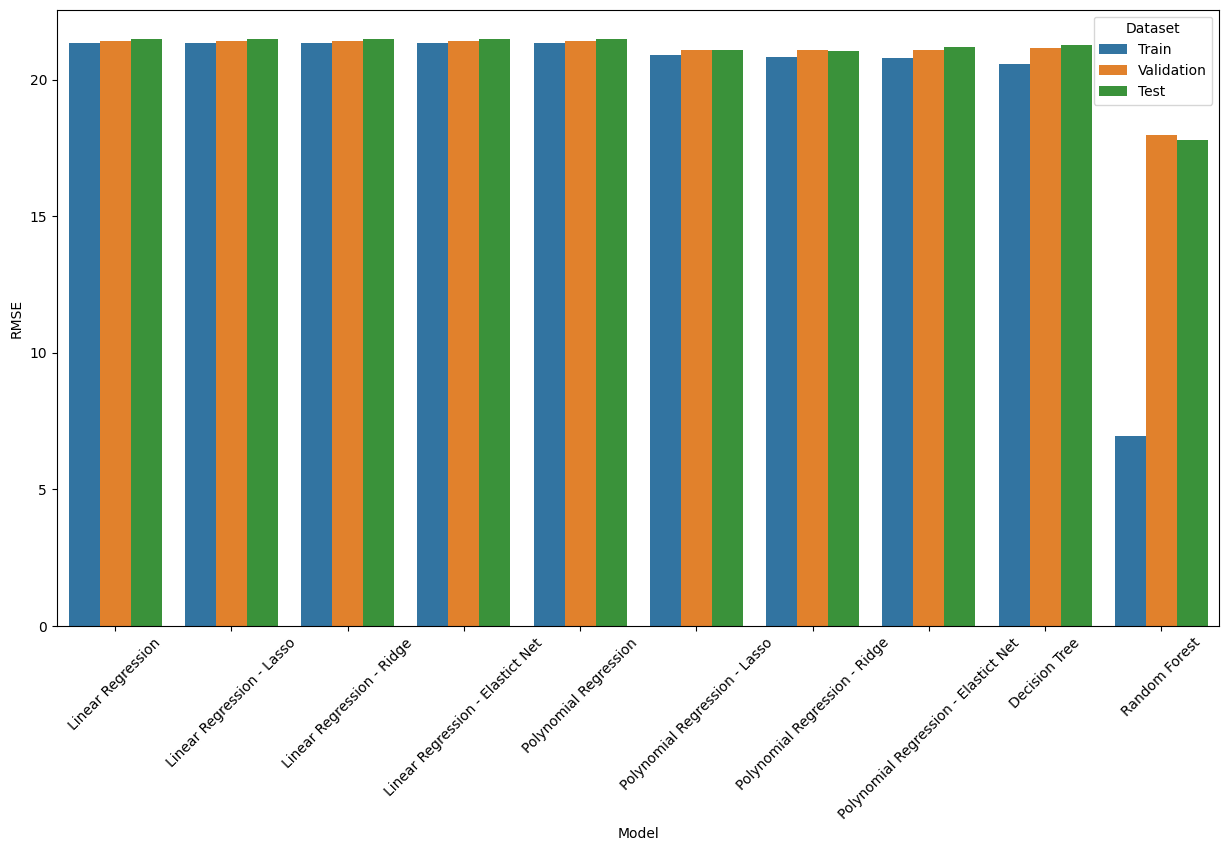

In [14]:
plt.figure(figsize=(15,8))
sns.barplot(x = 'Model', y = 'RMSE', hue = 'Dataset', data = df_results)
plt.xticks(rotation=45);